In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from nmfkl import *
from metrics import *
from utility import *

This demonstration shows using ResNet34 model. If you want to use any other model (for eg. mobilenet), change 'g' and 'h' accordingly in nmfkl.py. 

In [3]:
model = torchvision.models.resnet34(pretrained=True)

### Define key hyperparameters for concept extraction.
- steps: maximum steps for optimization
- epsilon: absolute loss difference for early stopping
- rank: the rank of matrix decomposition 
- lambda_val: lambda parameter of our optimization that weights KL-divergence
- learning_rate: learning rate for the optimization 
- patch_size: patch size for applying crops to the input images 
- batch_size: batch size for optimization 

In [4]:
steps = 22000
epsilon = 1e-3
rank = 25 
lambda_val = 1e-5
learning_rate = 5e-4
patch_size = 64 
batch_size=64

In [5]:
imagenet_class = 497

In [6]:
images_np = np.load('dataset/final_filtered_church_images.npz')['arr_0'].astype(np.uint8)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
analyzer = KL_NMF(
    model=model,
    imagenet_class=imagenet_class,
    images_np=images_np,
    rank=rank,
    patch_size=patch_size,
    batch_size=batch_size,
    epsilon=epsilon,
    steps=steps,
    lambda_val=lambda_val,
    learning_rate=learning_rate,
    device=device
)

In [9]:
print('accuracy before nmf is: ', analyzer.evaluate_accuracy_before_nmf())

accuracy before nmf is:  1.0


In [10]:
images_preprocessed = analyzer.preprocess_images(images_np)

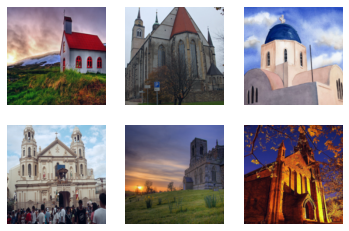

In [12]:
for i in range(6):
    img = images_preprocessed[i]
    img = img.cpu()
    img = np.array(img)
    img = img.transpose(1, 2, 0)
    img -= img.min()
    img /= img.max()
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.axis('off')

plt.show()

In [13]:
patches, activations_avg = analyzer.compute_activations(images_preprocessed)

In [14]:
U, W, mse_losses, kl_losses, total_losses = analyzer.nmf_kl_pgd(patches, activations_avg, images_preprocessed)

In [15]:
#some parameters set up for further processing and plotting of images 
model = model.eval().to(device)
g = nn.Sequential(*(list(model.children())[:-2]))
h = lambda x: model.fc(torch.mean(x, (2, 3))) 
h_2d = lambda x: model.fc(x)
crops, crops_u, w = patches, U, W
crops = np.moveaxis(torch_to_numpy(crops), 1, -1)
crops_u = torch_to_numpy(crops_u)
w = torch_to_numpy(w)
number_of_concepts = rank
W_= w

In [16]:
U_new = transform_to_nmf_basis2(images_preprocessed, W, g)

In [17]:
importance = estimate_importance(torch_to_numpy(U_new), W_, h, h_2d, imagenet_class, batch_size, number_of_concepts, device)

In [28]:
most_important_concepts = np.argsort(importance)[::-1][:5]

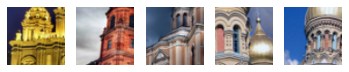

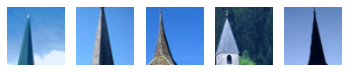

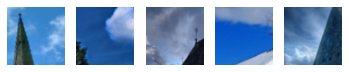

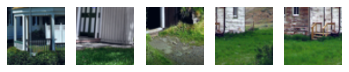

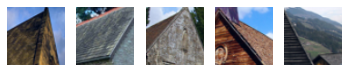

In [29]:
nb_crops = 5
def show(img, **kwargs):
  img = np.array(img)
  if img.shape[0] == 3:
    img = img.transpose(1, 2, 0)

  img -= img.min();img /= img.max()
  
  plt.imshow(img, **kwargs); plt.axis('off')
  

for c_id in most_important_concepts:
    best_crops_ids = np.argsort(crops_u[:, c_id])[::-1][:nb_crops]
    best_crops = crops[best_crops_ids]
    for i in range(nb_crops):
        plt.subplot(ceil(nb_crops/5), 5, i+1)
        
        show(best_crops[i])
    plt.show()
    
    print('\n\n')

In [30]:
print('the accuracy after nmf is:', compute_accuracy_after_nmf(images_preprocessed, W, g, h_2d, imagenet_class, device))

the accuracy after nmf is: tensor(1., device='cuda:0')


#### Complexity

In [31]:
print('C-gini sparsity of concept importance:', compute_gini_index(torch.tensor(importance)))

C-gini sparsity of concept importance: 0.9505462646484375


#### Faithfulness

In [32]:
images_u = transform_to_nmf_basis2(images_preprocessed, W, g)
delete = concept_deletion(images_u, W, h_2d, imagenet_class, importance)
insert = concept_insertion(images_u, W, h_2d, imagenet_class, importance)
C_del = compute_deletion_score(delete)
C_ins = compute_insertion_auc(insert)

In [33]:
print('area under curve for deletion metric', C_del)
print('area under curve for insertion metric', C_ins)

area under curve for deletion metric 0.8985652587475044
area under curve for insertion metric 0.9702027027027027


#### Sparsity of representation

In [34]:
print('sparsity of representation (U_Spr):', compute_sparsity(images_u))

sparsity of representation (U_Spr): 1.0


#### NMF projection error

In [35]:
def _batch_inference(model, dataset, batch_size=128, resize=None, device='cuda'):
    nb_batchs = ceil(len(dataset) / batch_size)
    start_ids = [i*batch_size for i in range(nb_batchs)]
    results = []
    with torch.no_grad():
        for i in start_ids:
            x = torch.tensor(dataset[i:i+batch_size])
            x = x.to(device)
            if resize:
                x = torch.nn.functional.interpolate(x, size=resize, mode='bilinear', align_corners=False)
            results.append(model(x).cpu())
    results = torch.cat(results)
    return results
    
original_activation = _batch_inference(g, images_preprocessed, batch_size=4, resize=None, device='cuda')
original_activation = original_activation.to('cuda')
A_original = torch.mean(original_activation, dim=(2, 3))
logits_original = h_2d(A_original)

In [36]:
mse, kl = evaluate_nmf_projection(images_preprocessed, W, g, h_2d, device, A_original, logits_original)
print('MSE loss:', mse)
print('KL loss:', kl)

MSE loss: 0.4132569134235382
KL loss: 0.30154818296432495


#### Stability

In [37]:
analyzer = KL_NMF(
            model=model,
            imagenet_class=imagenet_class,
            images_np=images_np,
            rank=rank,
            patch_size=patch_size,
            batch_size=batch_size,
            epsilon=epsilon,
            steps=steps,
            lambda_val=lambda_val,
            learning_rate=learning_rate,
            device=device
        )



w_list = extract_w_list(analyzer, images_np)
print('stability metric:', compute_stability(w_list)) 

stability metric: 0.8332114815711975
